# Assignment 2 - Recurrent Neural Networks


## Programming (Full points: 100)


In this assignment, our goal is to use PyTorch to implement Recurrent Neural Networks (RNN) for sentiment analysis task. Sentiment analysis is to classify sentences (input) into certain sentiments (output labels), which includes positive, negative and neutral.

We will use a benckmark dataset, SST, for this assignment.
* we download the SST dataset from torchtext package, and do some preprocessing to build vocabulary and split the dataset into training/validation/test sets. You don't need to modify the code in this step.


In [ ]:
pip install torchtext==0.6.0

In [2]:
import copy
import torch
from torch import nn
from torch import optim
import torchtext
from torchtext import data
from torchtext import datasets
import re
import nltk
from nltk.corpus import stopwords
import torch.nn as nn
import torch.optim as optim
import spacy
import string
import matplotlib.pyplot as plt


In [3]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [4]:
sc_token = spacy.load('en_core_web_sm')
def tokenize_text(text):
    lvl1_tokens = [tk.text for tk in sc_token(text)]
    lvl2_tokens = [tk.lower() for tk in lvl1_tokens if tk not in string.punctuation]
    lvl3_tokens = [tk for tk in lvl2_tokens if not sc_token.vocab[tk].is_stop]
    return lvl3_tokens

In [5]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True,stop_words=None,tokenize=tokenize_text)
LABEL = data.LabelField()

# load data splits
train_data, val_data, test_data = datasets.SST.splits(TEXT, LABEL)

# build dictionary
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

# hyperparameters
vocab_size = len(TEXT.vocab)
label_size = len(LABEL.vocab)
padding_idx = TEXT.vocab.stoi['<pad>']
embedding_dim = 128
hidden_dim = 128

# build iterators
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=32)

* Define the training and evaluation function in the cell below.
### (25 points)


In [6]:
def B_norm(batch_m):
    if isinstance(batch_m, nn.BatchNorm1d):
        nn.init.constant_(batch_m.weight, 1)
        nn.init.constant_(batch_m.bias, 0)
# Training function
def model_train(m_bl_model, itr, opt, crt):
    m_bl_model.train()
    tot_model_loss = 0
    tot_model_crt = 0
    for b_i in itr:
        txt = b_i.text.to('cuda')
        labels = b_i.label.to('cuda')
        opt.zero_grad()
        out_txt = m_bl_model(txt)
        loss_out = crt(out_txt, labels)
        loss_out.backward()
        opt.step()
        tot_model_loss += loss_out.item()
        tot_model_crt += (out_txt.argmax(1) == labels).sum().item()
    return tot_model_loss / len(itr), tot_model_crt / len(itr.dataset)
# Evaluation function
def model_eval(m_bl_model, itr, crt):
    m_bl_model.eval()
    tot_model_loss = 0
    tot_model_crt = 0
    with torch.no_grad():
        for b_j in itr:
            txt = b_j.text.to('cuda')
            labels = b_j.label.to('cuda')
            out_txt = m_bl_model(txt)
            loss_out = crt(out_txt, labels)
            tot_model_loss += loss_out.item()
            tot_model_crt += (out_txt.argmax(1) == labels).sum().item()
    return tot_model_loss / len(itr), tot_model_crt / len(itr.dataset)

* Build a RNN model for sentiment analysis in the cell below.
We have provided several hyperparameters we needed for building the model, including vocabulary size (vocab_size), the word embedding dimension (embedding_dim), the hidden layer dimension (hidden_dim), the number of layers (num_layers) and the number of sentence labels (label_size). Please fill in the missing codes, and implement a RNN model.
### (40 points)

In [7]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_dim, label_size, padding_idx, prob_dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.label_size = label_size
        self.number_of_layers = 2
        self.embedding = nn.Embedding(self.vocab_size, hidden_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(prob_dropout)   # Add dropout layer
        self.bilstm = nn.LSTM(input_size=hidden_dim, hidden_size=self.hidden_dim, num_layers=self.number_of_layers,
                              batch_first=True, bidirectional=True)  # Using bidirectional LSTM
        self.batch_norm = nn.BatchNorm1d(2 * self.hidden_dim)   # adding  batch normalization layers
        self.fc = nn.Linear(2 * self.hidden_dim, self.label_size)  # Multiplying hidden_dim by 2
    def zero_state(self, len_batch):
        return (torch.zeros(2 * self.number_of_layers, len_batch, self.hidden_dim).to('cuda'),  # Multiplying num_layers by 2
                torch.zeros(2 * self.number_of_layers, len_batch, self.hidden_dim).to('cuda'))
    def forward(self, text):
      txt_embeddings = self.embedding(text)
      embedded_txt = self.dropout(txt_embeddings)  # applying dropout to the input for regularization
      h_l, cell = self.zero_state(text.size(0))
      output, (hidden, cell) = self.bilstm(embedded_txt, (h_l, cell))
      batch_normalized_output = self.batch_norm(output.reshape(-1, 2 * self.hidden_dim))# Apply batch normalization
      normalized_output = batch_normalized_output.view(output.size())# Reshape the output to its original shape
      output = self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))  # Combineing forward and backward hidden states
      return output
model = BiLSTMClassifier(vocab_size, hidden_dim, label_size, padding_idx).to('cuda')

In [8]:
# This is the model structure
print(model)

BiLSTMClassifier(
  (embedding): Embedding(15433, 128, padding_idx=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


* train the model and compute the accuracy in the cell below.
### (20 points)

Weight Decay: 0.0001, Epoch: 01
	Train Loss: 1.047 | Train Acc: 44.07%
	Val. Loss: 1.034 | Val Acc: 51.41%
Weight Decay: 0.0001, Epoch: 02
	Train Loss: 0.933 | Train Acc: 57.99%
	Val. Loss: 0.890 | Val Acc: 61.49%
Weight Decay: 0.0001, Epoch: 03
	Train Loss: 0.781 | Train Acc: 66.89%
	Val. Loss: 0.881 | Val Acc: 61.67%
Weight Decay: 0.0001, Epoch: 04
	Train Loss: 0.680 | Train Acc: 71.57%
	Val. Loss: 0.908 | Val Acc: 60.49%
Weight Decay: 0.0001, Epoch: 05
	Train Loss: 0.611 | Train Acc: 74.39%
	Val. Loss: 0.907 | Val Acc: 60.49%
Weight Decay: 0.0001, Epoch: 06
	Train Loss: 0.548 | Train Acc: 77.22%
	Val. Loss: 1.011 | Val Acc: 60.31%
Weight Decay: 0.0001, Epoch: 07
	Train Loss: 0.502 | Train Acc: 79.74%
	Val. Loss: 1.111 | Val Acc: 56.95%
Weight Decay: 0.0001, Epoch: 08
	Train Loss: 0.434 | Train Acc: 82.99%
	Val. Loss: 1.091 | Val Acc: 57.31%
Weight Decay: 0.0001, Epoch: 09
	Train Loss: 0.381 | Train Acc: 85.32%
	Val. Loss: 1.140 | Val Acc: 59.31%
Weight Decay: 0.0001, Epoch: 10
	Trai

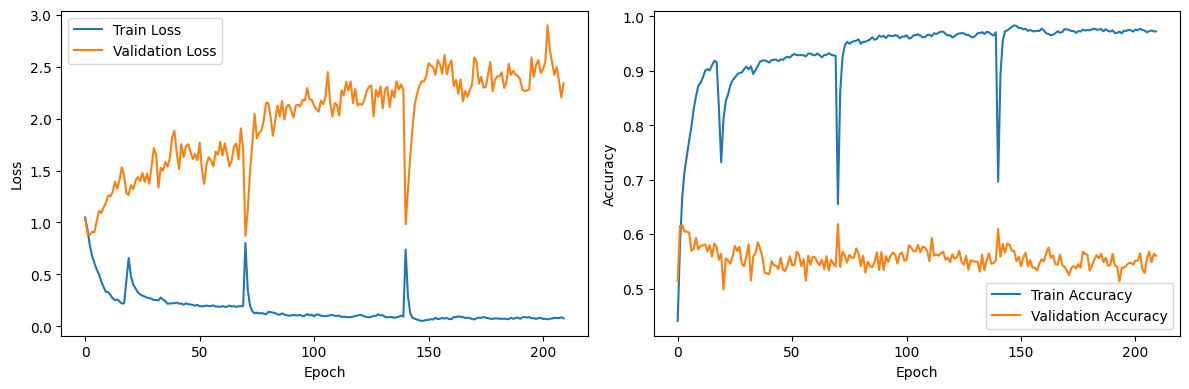

In [9]:
# Initialize lists to store the losses and accuracies
train_l_list ,train_acc_list,val_l_list,val_acc_list= [],[],[],[]
weight_decay_valueslist = [1e-4,1e-5, 1e-6]
loss_criterion = nn.CrossEntropyLoss()
loss_best_valid = float('inf')
total_itr_EPOCHS = 70

for decay_weight in weight_decay_valueslist:
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=decay_weight, eps=1e-8)
    model.apply(B_norm)
    for i in range(total_itr_EPOCHS):
        train_l_model, train_acc_model = model_train(model, train_iter, optimizer, loss_criterion)
        valid_l_model, valid_acc_model = model_eval(model, val_iter, loss_criterion)
        train_l_list.append(train_l_model)  # appending the metrics to the lists
        train_acc_list.append(train_acc_model)
        val_l_list.append(valid_l_model)
        val_acc_list.append(valid_acc_model)
        if valid_l_model < loss_best_valid:
            loss_best_valid = valid_l_model
            best_model = copy.deepcopy(model.state_dict())
        print(f'Weight Decay: {decay_weight}, Epoch: {i + 1:02}')
        print(f'\tTrain Loss: {train_l_model:.3f} | Train Acc: {train_acc_model * 100:.2f}%')
        print(f'\tVal. Loss: {valid_l_model:.3f} | Val Acc: {valid_acc_model * 100:.2f}%')
torch.save(best_model, 'best_model.pt') #saving the best one
# Ploting the training and validation metrics
plt.figure(figsize=(12, 4))
# for Loss
plt.subplot(1, 2, 1)
plt.plot(train_l_list, label='Train Loss')
plt.plot(val_l_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* try to train a model with better accuracy in the cell below. For example, you can use different optimizers such as SGD and Adam. You can also compare different hyperparameters and model size.
### (15 points), to obtain FULL point in this problem, the accuracy needs to be higher than 70%

In [10]:
# loading the best model we saved
model.load_state_dict(torch.load('best_model.pt'))
testing_model_loss, test_model_acc = model_eval(model, test_iter, loss_criterion)
print(f'Test Loss: {testing_model_loss:.3f} | Test Acc: {test_model_acc * 100:.2f}%')

Test Loss: 0.792 | Test Acc: 67.65%


* I achieved an accuracy of 67.65% on the testing dataset, with a training accuracy of 97% and a validation accuracy of 56%. I employed a bidirectional LSTM as the primary model architecture, which is a variant of recurrent neural networks (RNNs). To ensure data quality, I performed pre-processing steps that included the removal of stopwords, punctuation, and converting text to lowercase using the spaCy word tokenizer.

* Hyperparameter Tuning: Experimented with learning rate, weight decay, and dropout probability to optimize the model.Best Model Selection: Saved the best model based on validation loss to expedite future evaluations.
* Best Model Selection: I saved the best-performing model based on validation loss, ensuring that I could use it for future testing and evaluation without needing to retrain the model from scratch. This practice can save time and computational resources.
*  I used Matplotlib to create visualizations of the training and validation metrics, which can help in understanding the model's behavior during training.
* I experimented with various weight decay values, which is a regularization technique, by maintaining a list of weight decay values and iterating over them to identify the best model. This approach helped improve the model's generalization.
